In [12]:
import numpy as np
import pandas as pd

COLORS = {
    "Gray": np.array([169, 169, 169]),
    "LightGray": np.array([217, 217, 217]),
    "DarkGray": np.array([117, 117, 117]),
    "DarkRed": np.array([238, 125, 95]),
    "LightRed": np.array([247, 207, 196]),
    "DarkRedBorder": np.array([202, 65, 35]),
    "Yellow": np.array([255, 201, 67]),
    "LightYellow": np.array([255, 236, 189]),
    "LightGreen": np.array([213, 243, 214]),
    "Green": np.array([131, 211, 127]),
    "GreenBorder": np.array([88, 153, 84]),
    "LightBlue": np.array([201, 228, 252]),
    "LightBlueBorder": np.array([94, 171, 248]),
    "Blue": np.array([94, 171, 248]),
    "Black": np.array([40, 45, 50]),
    "White": np.array([255, 255, 255]),
    "LightPink": np.array([246, 196, 233]),
    "Pink": np.array([229, 87, 189]),
}

# Install packages
```cmd
pip install psycopg

```


In [13]:
import psycopg
from psycopg.rows import dict_row

def getDbConn():
    return psycopg.connect(
        host="localhost",
        dbname="tdt4900",
        user="postgres",
        password="postgres",
        row_factory=dict_row
    )


# Execution Time vs. Levels

In [3]:
db_conn = getDbConn()
execution_times = {}

simulation_ids = [124,123,122,123,125,126,127]

for sim_id in simulation_ids:
    simulation = db_conn.cursor().execute(f'SELECT * FROM "Simulations" WHERE "Id" = {sim_id}').fetchall()[0]
    graph_id = simulation['GraphId']

    execution_time = simulation['AlgorithmExecutionTime']
    level = db_conn.cursor().execute(f'SELECT "Levels" FROM "Graphs" WHERE "Id" = {graph_id}').fetchall()[0]['Levels']



    execution_times[level] = execution_time

db_conn.close()

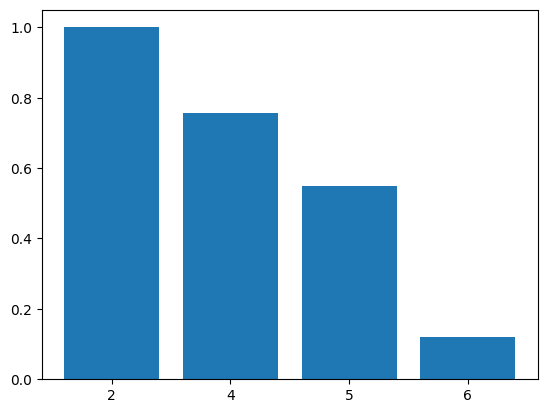

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fix, ax = plt.subplots()
x = np.array(sorted(execution_times.keys()))
y = np.array([execution_times[i] for i in x])

# Normalize (
norm_y = y / (y.max())

x = [str(num + 1) for num in x]

plt.bar(x, norm_y)
plt.show()

# Execution Time / Path Length
Also includes standard deviation from execution times

In [5]:
db_conn = getDbConn()
execution_times = {}

sim_batch_ids = {49, 50, 51}

for sim_batch_id in sim_batch_ids:

    simulations = db_conn.cursor().execute(f'SELECT * FROM "Simulations" WHERE "SimulationBatchId" = {sim_batch_id}').fetchall()

    levels = db_conn.cursor().execute(f'SELECT * FROM "Graphs" INNER JOIN "Simulations" ON "Simulations"."GraphId" = "Graphs"."Id" WHERE "Simulations"."SimulationBatchId" = {sim_batch_id} LIMIT 1').fetchall()[0]['Levels']

    execution_times[levels] = []

    for simulation in simulations:
        graph_id = simulation['GraphId']
        shortest_path_length = simulation['ShortestPathLength']
        execution_time = simulation['AlgorithmExecutionTime']

        execution_time_factor = execution_time / shortest_path_length

        execution_times[levels].append(execution_time_factor)

db_conn.close()

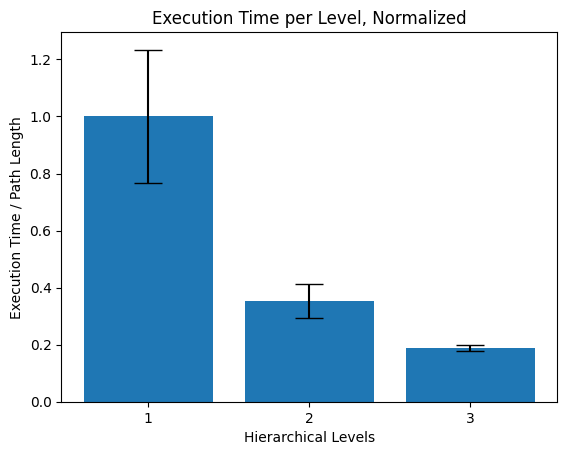

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fix, ax = plt.subplots()
x = np.array(sorted(execution_times.keys()))

y = []
conf_intervals = []

for level in x:
    val = execution_times[level]
    mean = np.mean(val)
    std_dev = np.std(val) / 2.0
    y.append(mean)
    conf_intervals.append(std_dev)

x = [str(num) for num in x]
y = np.array(y)
conf_intervals = np.array(conf_intervals)

norm_y = y / (y.max())
norm_conf_intervals = conf_intervals / y.max()

plt.bar(x, norm_y, yerr=norm_conf_intervals, capsize=10)

plt.title('Execution Time per Level, Normalized')
plt.ylabel('Execution Time / Path Length')
plt.xlabel('Hierarchical Levels')

plt.show()

# Execution Time / Path Length - Compared to Path Length on single level

In [140]:
import pandas as pd

db_conn = getDbConn()
execution_times = {}

sim_batch_ids = {49, 50, 51, 52}

data = []

for sim_batch_id in sim_batch_ids:

    simulations = db_conn.cursor().execute(f'SELECT * FROM "Simulations" WHERE "SimulationBatchId" = {sim_batch_id}').fetchall()

    levels = db_conn.cursor().execute(f'SELECT * FROM "Graphs" INNER JOIN "Simulations" ON "Simulations"."GraphId" = "Graphs"."Id" WHERE "Simulations"."SimulationBatchId" = {sim_batch_id} LIMIT 1').fetchall()[0]['Levels']

    for simulation in simulations:
        graph_id = simulation['GraphId']
        shortest_path_length = simulation['ShortestPathLength']
        execution_time = simulation['AlgorithmExecutionTime']
        execution_time_factor = execution_time / shortest_path_length

        data.append([levels, sim_batch_id, sim_id, shortest_path_length, execution_time, execution_time_factor])

df = pd.DataFrame(data, columns=["level", "sim_batch_id", "sim_id", "shortest_path_length", "execution_time", "execution_time_factor"])
df.sort_values("level", ascending=True, inplace=True)


db_conn.close()

In [141]:
import plotly.express as px
import plotly.graph_objects as go

# Normalize execution time
df = df[(df["shortest_path_length"] > 2) & (df["shortest_path_length"] < 60)]
fig = px.histogram(df, x="shortest_path_length", y="execution_time",
             color='level', barmode='group',  histfunc='avg', log_y=False, log_x=True, nbins=55, width=1200, height=600, opacity=0.35)

color_map = {1: "blue", 2:"red", 3:"green", 4: "purple"}

# Step 1: Group and bin data manually
bins = np.histogram_bin_edges(df["shortest_path_length"], bins=40)
df["bin"] = pd.cut(df["shortest_path_length"], bins=bins)

# Step 2: Compute average per bin per level
grouped = df.groupby(["bin", "level"])["execution_time"].mean().reset_index()

# Step 3: Convert bin to numeric midpoint for plotting
grouped["bin_mid"] = grouped["bin"].apply(lambda x: x.mid)

# Step 4: Overlay trend lines
for level in grouped["level"].unique():
    sub = grouped[grouped["level"] == level]
    fig.add_trace(go.Scatter(
        x=sub["bin_mid"],
        y=sub["execution_time"],
        mode='lines',
        name=f"Level {level}",
        opacity=1,
        line=dict(width=2, dash='dashdot', color=color_map[level])  # Optional: dashed lines for distinction
    ))

n_values = np.linspace(df["shortest_path_length"].min(), df["shortest_path_length"].max(), 500)
o_n2 = 6 * (n_values ** 2)
fig.add_trace(go.Scatter(
        x=n_values,
        y=o_n2,
        mode='lines',
        name='O(n²)',
        opacity=1,
        line=dict(width=2, dash='solid')  # Optional: dashed lines for distinction
    ))

fig.show()


/var/folders/c7/f_kbfcbs2c3dfpp8lj5y1z300000gn/T/ipykernel_26851/1080963170.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# Visualize Tagged Graph

In [9]:
db_conn = getDbConn()

nodes = []

simulation_ids = 124

nodes_db = db_conn.cursor().execute(f'SELECT * FROM "Node" LIMIT 1500').fetchall()
for n in nodes_db:
    nodes.append((n['Id'], n['X'], n['Y'], 2))

df = pd.DataFrame(nodes, columns=["Id", "X", "Y", "Size"])

db_conn.close()

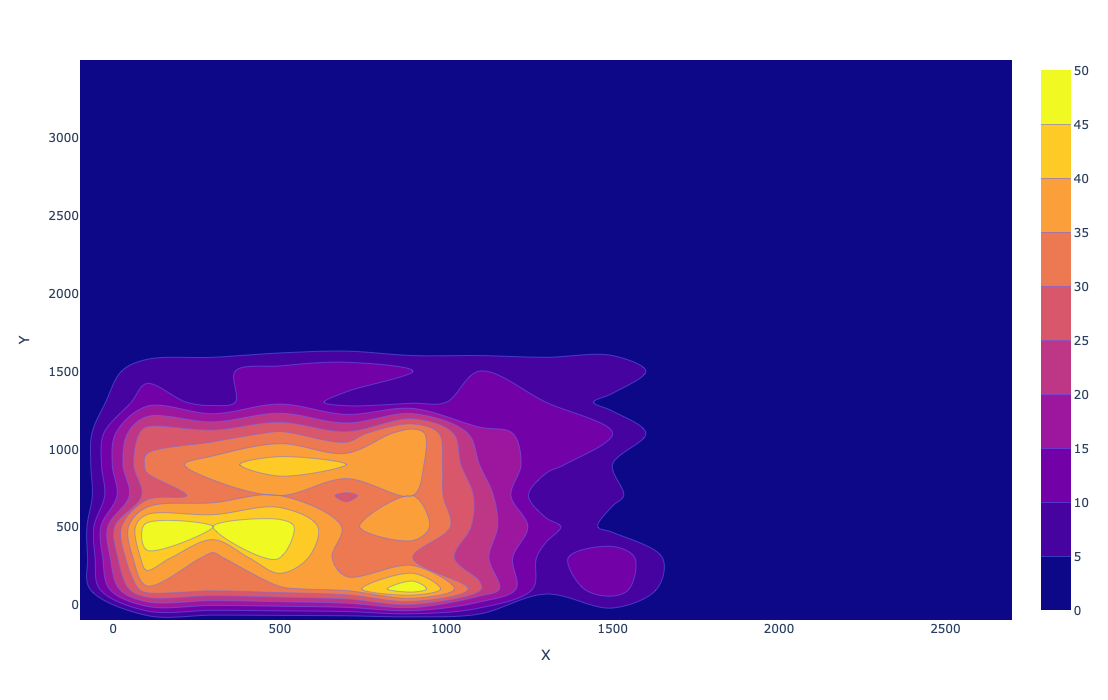

In [10]:
import plotly.express as px

fig = px.density_contour(df, x="X", y="Y",  height=700, width=700)
fig.update_traces(contours_coloring="fill")

fig.show()
